In [1]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
folder_path = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'
os.chdir(folder_path)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np
# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new

# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Setup data

In [2]:
import scanpy as sc

###########################################
# set path to the downloaded UOTReg folder
###########################################
DATASET_PATH = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'
statefate = sc.read(DATASET_PATH +  "data/timedata/scrna-statefate/invitro-hvg.h5ad")

# Note: this is the top 1000 HVGs of embryoid, already normalized to 1e4 and log1p transformed
print(statefate.shape)


(130861, 1622)


In [3]:
# Convert PCA array to Pandas data frame
statefate_pc = statefate.obsm['X_pca'][:,0:20]

statefate_pc_df = pd.DataFrame(
    data=statefate_pc,
    index=statefate.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(statefate_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(statefate_pc_df))  # Should be <class 'pandas.DataFrame'>
print(statefate_pc_df.shape)

# get the time snapshots info
cells_meta = statefate.obs
unique_time = statefate.obs['time'].unique().to_list()
print(unique_time)

<class 'pandas.core.frame.DataFrame'>
(130861, 20)
[6, 4, 2]


In [4]:
Y_time_samplers = []

# get samplers for different time snapshots
for id in unique_time:
    X_k = statefate_pc_df[statefate.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

54116
48496
28249


<Figure size 600x200 with 0 Axes>

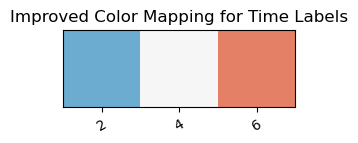

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color gradient with higher contrast
color_palette = sns.color_palette("RdBu_r", n_colors=3)  # Using reversed Red-Blue colormap

# Assign colors to time labels
time_labels = [2, 4, 6]
color_dict = dict(zip(time_labels, color_palette))

# Show the new color mapping
plt.figure(figsize=(6, 2))
sns.palplot(color_palette)
plt.xticks(range(3), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()

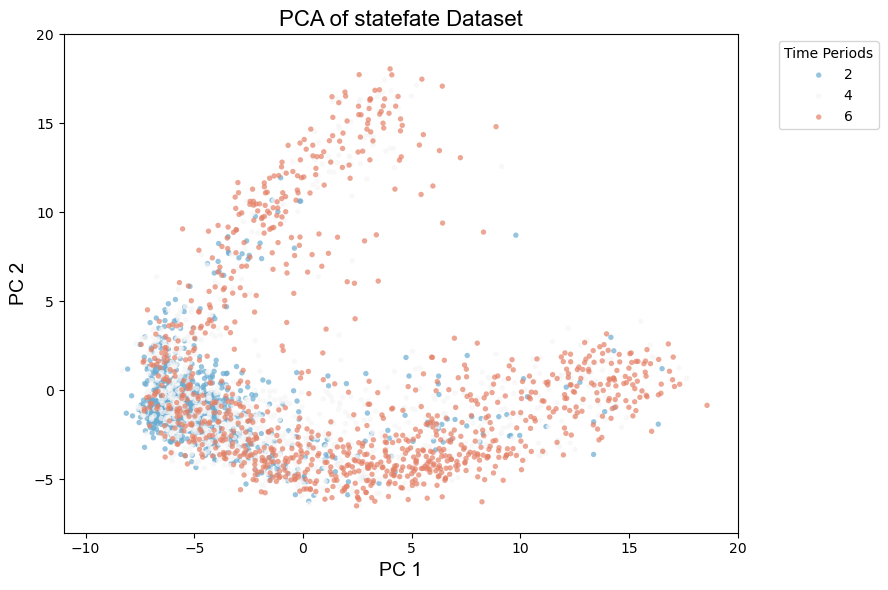

In [6]:
# Extract the first two principal components
pc1 = statefate.obsm['X_pca'][:, 0]
pc2 = statefate.obsm['X_pca'][:, 1]

# Customizable parameters
alpha_values = {2: 0.7, 4: 0.7, 6: 0.7}
z_orders = {2: 3, 4: 2, 6: 1}
marker_size = 15  # Adjust scatter size
font_family = "Arial"  # Change font family
font_size_label = 14   # Font size for axis labels
font_size_title = 16   # Font size for title

# Allow custom axis limits (change as needed)
x_range = (-11, 20)
y_range = (-8, 20)

plt.figure(figsize=(9, 6))

# Plot each time group with no edge color, ensuring points are fully filled
for label in time_labels:
    subset = statefate.obs['time'] == label
    idx = np.where(subset)[0]                # indices of this group
    if idx.shape[0] > 1000:                  # if more than 1000, randomly sample
        idx = np.random.choice(idx, 1000, replace=False)
    plt.scatter(
        pc1[idx], 
        pc2[idx], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_size,  # Adjustable marker size
        alpha=alpha_values[label], 
        edgecolors='none'  # Ensure no border for scatter points
    )

# Move the legend outside the plot
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Customize font styles
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of statefate Dataset", fontsize=font_size_title, fontfamily=font_family)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


## Estimated distributions

In [7]:
# loading the learned generators
size = 256
DIM = 20
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G2.parameters()]))

###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"

G1.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/estimated_distribution/G_statefate20_256_Day3_40_tau1.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/estimated_distribution/G_statefate20_256_Day4_40_tau1.pth"))
G3.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/estimated_distribution/G_statefate20_256_Day5_40_tau1.pth"))

G params: 207892


<All keys matched successfully>

In [8]:
# check learned distributions

G1.eval(); G2.eval(); G3.eval()
data_num = 2000
data_learned1 = G1(Z_sampler.sample(data_num)).detach().numpy()
data_learned2 = G2(Z_sampler.sample(data_num)).detach().numpy()
data_learned3 = G3(Z_sampler.sample(data_num)).detach().numpy()

# Combine original and new time labels in chronological order
time_labels = [
    'Day 2', 'Day 3 (predicted)', 'Day 4 (predicted)', 'Day 5 (predicted)', 'Day 6', 
]

# Define data sources accordingly (assuming you already have the data)
data_dict_ori = {
    'Day 2': statefate.obsm['X_pca'][statefate.obs['time'] == 2],
    'Day 4': statefate.obsm['X_pca'][statefate.obs['time'] == 4],
    'Day 6': statefate.obsm['X_pca'][statefate.obs['time'] == 6],
}

data_dict = {
    'Day 2': statefate.obsm['X_pca'][statefate.obs['time'] == 2],
    'Day 3 (predicted)': data_learned1,
    'Day 4 (predicted)': data_learned2,
    'Day 5 (predicted)': data_learned3,
    'Day 6': statefate.obsm['X_pca'][statefate.obs['time'] == 6]
}

### Visualization: estimated distributions

<Figure size 600x200 with 0 Axes>

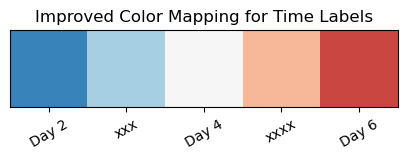

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color gradient with higher contrast
color_palette = sns.color_palette("RdBu_r", n_colors=5)  # Using reversed Red-Blue colormap

# Assign colors to time labels
time_labels = [
    'Day 2', 'xxx', 'Day 4', 'xxxx', 'Day 6', 
]
color_dict = dict(zip(time_labels, color_palette))

# Show the new color mapping
plt.figure(figsize=(6, 2))
sns.palplot(color_palette)
plt.xticks(range(5), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()

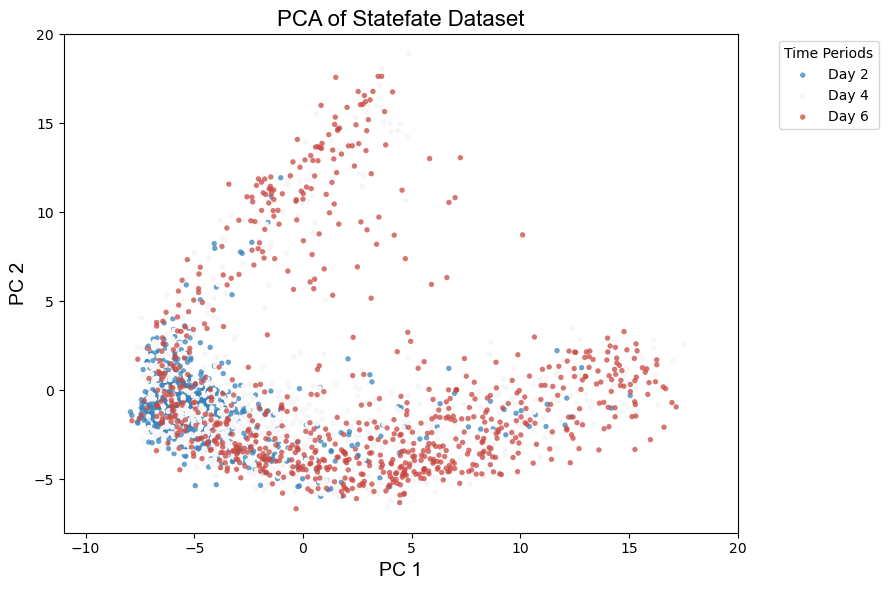

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the first two principal components
pc1 = statefate.obsm['X_pca'][:, 0]
pc2 = statefate.obsm['X_pca'][:, 1]

# ----- settings -----
z_orders = {
    'Day 2': 1,
    'Day 4': 2,
    'Day 6': 5,
}

marker_sizes = {
    'Day 2': 15,
    'Day 4': 15,
    'Day 6': 15,
}

alpha_values = {
    'Day 2': 0.75,
    'Day 4': 1,
    'Day 6': 0.75,
}

font_family = "Arial"
font_size_label = 14
font_size_title = 16
x_range = (-11, 20)
y_range = (-8, 20)

# reproducible subsampling
rng = np.random.default_rng(42)
n_per_label = 800  # <- subsample size

plt.figure(figsize=(9, 6))

for label in time_labels:
    if label == "xxx": continue
    elif label == "xxxx": continue
    data = data_dict_ori[label]               # shape: (N, 2) or (N, d) but we're using [:, :2]
    idx = rng.choice(len(data), n_per_label, replace=False)
    subs = data[idx, :2]                  # use first two PCs if data has >2 cols

    if(label=="Day 4"):
        plt.scatter(
            subs[:, 0], subs[:, 1],
            c=[color_dict[label]],
            label=label,
            s=marker_sizes[label],
            alpha=alpha_values[label],
            edgecolors='none', # can substitute as black
            zorder=z_orders[label]
        )
    else:
        plt.scatter(
            subs[:, 0], subs[:, 1],
            c=[color_dict[label]],
            label=label,
            s=marker_sizes[label],
            alpha=alpha_values[label],
            edgecolors='none',
            zorder=z_orders[label]
        )

plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(x_range); plt.ylim(y_range)
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Statefate Dataset", fontsize=font_size_title, fontfamily=font_family)
plt.tight_layout()
plt.show()


<Figure size 800x200 with 0 Axes>

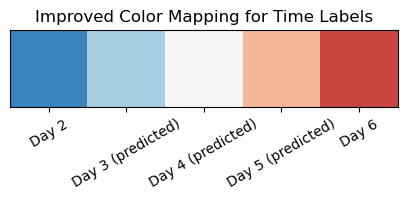

In [11]:
time_labels = [
    'Day 2', 'Day 3 (predicted)', 'Day 4 (predicted)', 'Day 5 (predicted)', 'Day 6' 
]

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=5)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Show the updated color mapping
plt.figure(figsize=(8, 2))
sns.palplot(color_palette)
plt.xticks(range(5), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()


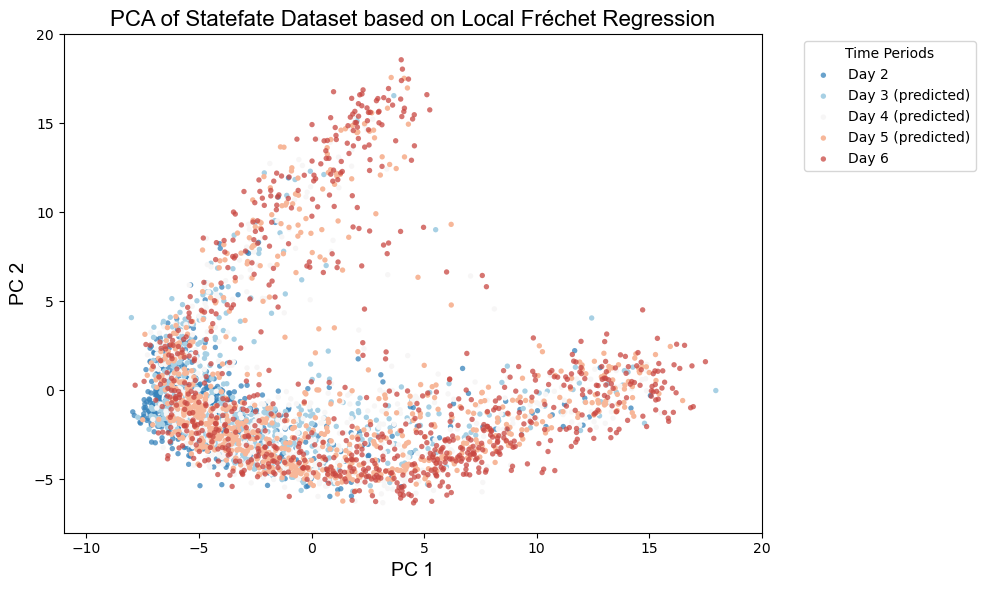

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- config (as you had) ---
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16
x_range = (-11, 20)
y_range = (-8, 20)

z_orders = {
    'Day 2': 1,
    'Day 3 (predicted)': 2,
    'Day 4 (predicted)': 3,
    'Day 5 (predicted)': 4,
    'Day 6': 5,
}

marker_sizes = {
    'Day 2': 15,
    'Day 3 (predicted)': 15,
    'Day 4 (predicted)': 15,
    'Day 5 (predicted)': 15,
    'Day 6': 15,
}

alpha_values = {
    'Day 2': 0.75,
    'Day 3 (predicted)': 1,
    'Day 4 (predicted)': 1,
    'Day 5 (predicted)': 1,
    'Day 6': 0.75,
}

# --- subsample & plot ---
rng = np.random.default_rng(42)   # reproducible
n_per_label = 800                 # guaranteed available per label

plt.figure(figsize=(10, 6))

for label in time_labels:
    data = data_dict[label]               # shape: (N, 2) or (N, d) but we're using [:, :2]
    idx = rng.choice(len(data), n_per_label, replace=False)
    subs = data[idx, :2]                  # use first two PCs if data has >2 cols

    if(label=="Day 4 (predicted)"):
        plt.scatter(
            subs[:, 0], subs[:, 1],
            c=[color_dict[label]],
            label=label,
            s=marker_sizes[label],
            alpha=alpha_values[label],
            edgecolors='none', # can substitute as black
            zorder=z_orders[label]
        )
    else:
        plt.scatter(
            subs[:, 0], subs[:, 1],
            c=[color_dict[label]],
            label=label,
            s=marker_sizes[label],
            alpha=alpha_values[label],
            edgecolors='none',
            zorder=z_orders[label]
        )

plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Statefate Dataset based on Local Fréchet Regression", fontsize=font_size_title, fontfamily=font_family)
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(x_range); plt.ylim(y_range)
plt.tight_layout()
plt.show()


## Construct New Samplers

In [13]:
Y_time_samplers = []

# get samplers for different time snapshots
unique_time = [2,4,6]
for id in unique_time:
    X_k = statefate_pc_df[statefate.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

28249
48496
54116


In [14]:
# Construct Y_time_samplers_learned with X_k as a pandas DataFrame
# --- Assumes: torch, numpy already imported; G1..G7, Z_sampler defined & loaded; tensorDataset/tensorSampler available
import pandas as pd
import torch

torch.manual_seed(0)

day_labels = [3,4,5]
generators = [G1, G2, G3]
n_per_day  = 30000
DIM        = Z_sampler.dim if hasattr(Z_sampler, "dim") else 20   # keep DIM consistent
device     = torch.device("cpu")

# Choose column names for the DataFrame
try:
    X_cols = list(statefate_pc_df.columns)[:DIM]
    if len(X_cols) != DIM:
        raise ValueError("statefate_pc_df has incompatible number of columns.")
except Exception:
    X_cols = [f"pc{i+1}" for i in range(DIM)]

for G in generators:
    G.eval()

Y_time_samplers_learned = []
for day, G in zip(day_labels, generators):
    with torch.no_grad():
        Z_t   = Z_sampler.sample(n_per_day)                   # torch [n, DIM]
        X_t   = G(Z_t).detach().to(device).float()            # torch [n, DIM]
        X_np  = X_t.cpu().numpy()                             # numpy [n, DIM]
        X_k   = pd.DataFrame(X_np, columns=X_cols)            # <-- pandas DataFrame

    cells_k = pd.DataFrame({
        "cell_id": [f"d{day}_{i}" for i in range(n_per_day)],
        "time":    day,
        "day":     day
    })

    dataset_k = tensorDataset(X_k, cells_k)
    sampler_k = tensorSampler(dataset_k, device="cpu")
    Y_time_samplers_learned.append(sampler_k)

    print(f"Day {day}: dataset size = {len(dataset_k)}, X_k shape = {X_k.shape}, columns = {X_k.columns[:3].tolist()}...")


Day 3: dataset size = 30000, X_k shape = (30000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 4: dataset size = 30000, X_k shape = (30000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 5: dataset size = 30000, X_k shape = (30000, 20), columns = ['PC1', 'PC2', 'PC3']...


In [15]:
Y_time_samplers_mix = [Y_time_samplers[0], *Y_time_samplers_learned, Y_time_samplers[-1]]

## Visualization: Trajectories

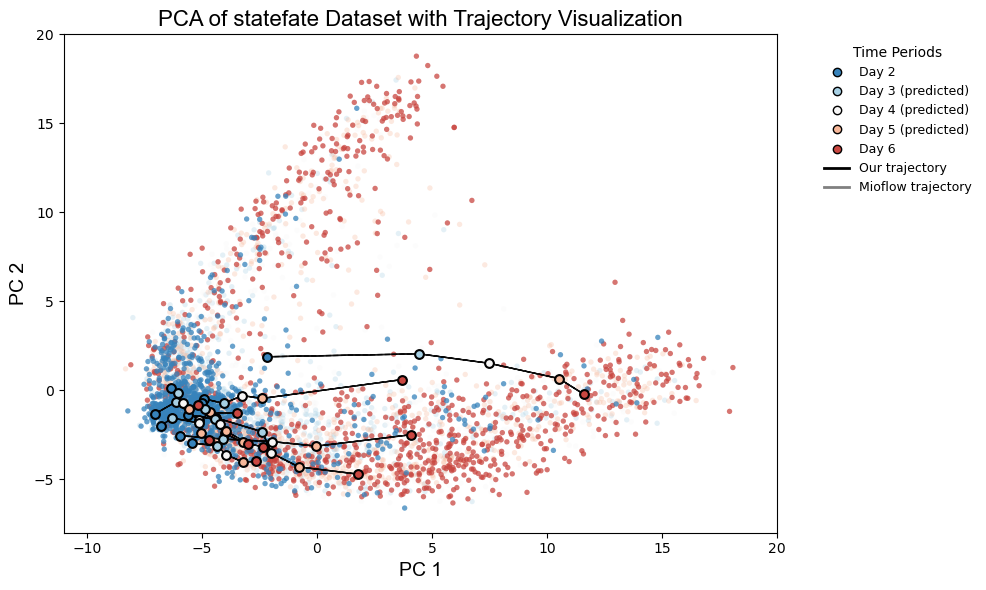

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=5)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Load the transport maps for all 8 steps

###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
T_maps = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/reg20/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# Sample 10 points from Ysamplers_new[0]
num_points = 10
data = Y_time_samplers_mix[0].sample(1000)
indices = np.random.choice(data.shape[0], num_points, replace=False)
data_selected = data[indices]

# Convert data to numpy for visualization
trajectory = [data_selected.detach().numpy()]
trajectory_time_labels = ['Day 2', 'Day 3 (predicted)', 'Day 4 (predicted)', 'Day 5 (predicted)', 'Day 6']
trajectory_colors = plt.cm.viridis(np.linspace(0, 1, 6))

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)  # Shape: (9, num_points, feature_dim)
traj_reg = trajectory

# Define visualization parameters
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-11, 20)
y_range = (-8, 20)

z_orders = {
    'Day 2': 10,
    'Day 3 (predicted)': 2,
    'Day 4 (predicted)': 4,
    'Day 5 (predicted)': 6,
    'Day 6': 9,
}

marker_sizes = {
    'Day 2': 15,
    'Day 3 (predicted)': 15,
    'Day 4 (predicted)': 15,
    'Day 5 (predicted)': 15,
    'Day 6': 15,
}

alpha_values = {
    'Day 2': 0.75,
    'Day 3 (predicted)': 0.3,
    'Day 4 (predicted)': 0.3,
    'Day 5 (predicted)': 0.3,
    'Day 6': 0.75,
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original dataset with different colors
for label in time_labels:
    data = data_dict[label]
    idx = rng.choice(len(data), 1000, replace=False)
    data = data[idx, :2] 
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  
        alpha=alpha_values[label], 
        edgecolors='none',
        zorder=z_orders[label]
    )
    
# Plot sampled points and their trajectories with higher z-order
# 1,7,9 ,3(potentially)  
for i in range(current_data.shape[0]):
    # traj_color = trajectory_colors[i]  # Assign unique color to each trajectory
    traj_color = "black"

    for j in range(len(trajectory) - 1):
        # Plot line segments between consecutive steps
        plt.plot([trajectory[j, i, 0], trajectory[j + 1, i, 0]], 
                 [trajectory[j, i, 1], trajectory[j + 1, i, 1]], 
                 linestyle='--', color=traj_color, linewidth=1, alpha=0.8, zorder=10)  # Higher z-order for lines

        # Add arrow to indicate direction
        plt.arrow(trajectory[j, i, 0], trajectory[j, i, 1],
                  trajectory[j + 1, i, 0] - trajectory[j, i, 0],
                  trajectory[j + 1, i, 1] - trajectory[j, i, 1],
                  color=traj_color, alpha=0.9, head_width=0.1, head_length=0.2, zorder=11)

        # Add intermediate points with corresponding color and black border
        step_label = trajectory_time_labels[j]  # Get the corresponding time label
        plt.scatter(trajectory[j, i, 0], trajectory[j, i, 1], 
                    color=[color_dict[step_label]],  # Assign color based on time point
                    s=40, edgecolors='black', linewidth=1.5, zorder=12)

    # Plot the last point in the trajectory with its corresponding color
    plt.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1], 
                color=[color_dict[trajectory_time_labels[-1]]],  
                s=40, edgecolors='black', linewidth=1.5, zorder=12)

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of statefate Dataset with Trajectory Visualization", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
# Custom legend elements using Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 2'], markersize=6, label='Day 2'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 3 (predicted)'], markersize=6, label='Day 3 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 4 (predicted)'], markersize=6, label='Day 4 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 5 (predicted)'], markersize=6, label='Day 5 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 6'], markersize=6, label='Day 6'),
    Line2D([0], [0], color='black', linewidth=2, label='Our trajectory'),
    Line2D([0], [0], color='gray', linewidth=2, label='Mioflow trajectory')
]

# Add custom legend outside the plot
plt.legend(
    handles=legend_elements, 
    title="Time Periods", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    frameon=False,
    fontsize=9
)

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

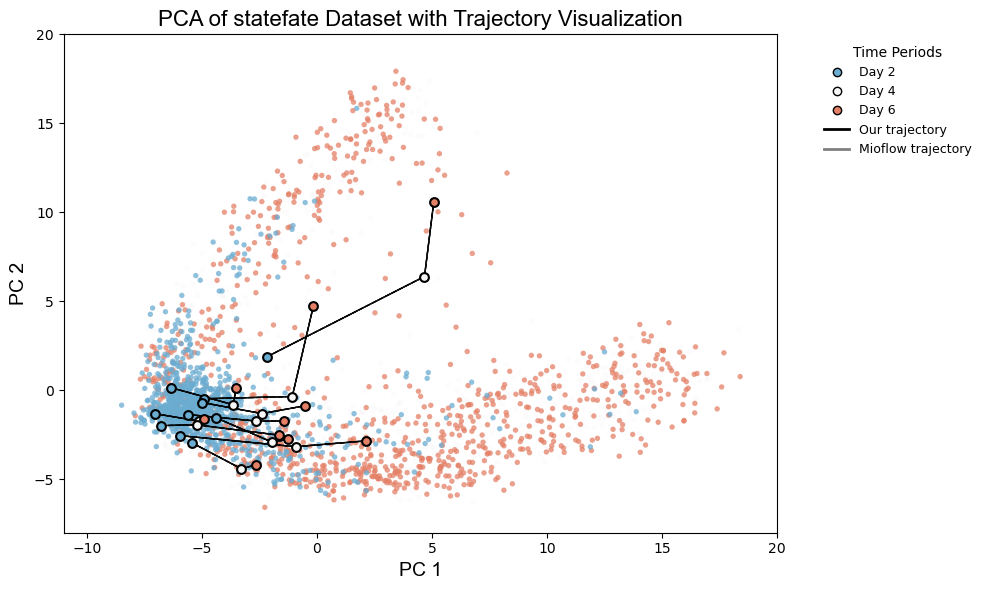

In [17]:
# maps from direct composing

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=3)

trajectory_time_labels = ['Day 2', 'Day 4', 'Day 6']
# Assign colors to each time label
color_dict = dict(zip(trajectory_time_labels, color_palette))

# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
T_maps = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/direct20/T_map_{i+1}_to_{i+2}.pt") for i in range(2)]

# Sample 10 points from Ysamplers_new[0]
num_points =10
data = Y_time_samplers_mix[0].sample(1000)
indices = np.random.choice(data.shape[0], num_points, replace=False)
# data_selected = data[indices] # use the same initial cells

# Convert data to numpy for visualization
trajectory = [data_selected.detach().numpy()]
trajectory_time_labels = ['Day 2', 'Day 4', 'Day 6']
trajectory_colors = plt.cm.viridis(np.linspace(0, 1, 3))

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)  # Shape: (9, num_points, feature_dim)
traj_direct = trajectory

# Define visualization parameters
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-11, 20)
y_range = (-8, 20)

z_orders = {
    'Day 2': 10,
    'Day 4': 4,
    'Day 6': 9,
}

marker_sizes = {
    'Day 2': 15,
    'Day 4': 15,
    'Day 6': 15,
}

alpha_values = {
    'Day 2': 0.75,
    'Day 4': 0.3,
    'Day 6': 0.75,
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original dataset with different colors
for label in trajectory_time_labels:
    data = data_dict_ori[label]
    idx = rng.choice(len(data), 1000, replace=False)
    data = data[idx, :2]
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  
        alpha=alpha_values[label], 
        edgecolors='none',
        zorder=z_orders[label]
    )
    
# Plot sampled points and their trajectories with higher z-order
# 1,7,9 ,3(potentially)  
for i in range(current_data.shape[0]):
    # traj_color = trajectory_colors[i]  # Assign unique color to each trajectory
    traj_color = "black"

    for j in range(len(trajectory) - 1):
        # Plot line segments between consecutive steps
        plt.plot([trajectory[j, i, 0], trajectory[j + 1, i, 0]], 
                 [trajectory[j, i, 1], trajectory[j + 1, i, 1]], 
                 linestyle='--', color=traj_color, linewidth=1, alpha=0.8, zorder=10)  # Higher z-order for lines

        # Add arrow to indicate direction
        plt.arrow(trajectory[j, i, 0], trajectory[j, i, 1],
                  trajectory[j + 1, i, 0] - trajectory[j, i, 0],
                  trajectory[j + 1, i, 1] - trajectory[j, i, 1],
                  color=traj_color, alpha=0.9, head_width=0.1, head_length=0.2, zorder=11)

        # Add intermediate points with corresponding color and black border
        step_label = trajectory_time_labels[j]  # Get the corresponding time label
        plt.scatter(trajectory[j, i, 0], trajectory[j, i, 1], 
                    color=[color_dict[step_label]],  # Assign color based on time point
                    s=40, edgecolors='black', linewidth=1.5, zorder=12)

    # Plot the last point in the trajectory with its corresponding color
    plt.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1], 
                color=[color_dict[trajectory_time_labels[-1]]],  
                s=40, edgecolors='black', linewidth=1.5, zorder=12)

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of statefate Dataset with Trajectory Visualization", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
# Custom legend elements using Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 2'], markersize=6, label='Day 2'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 4'], markersize=6, label='Day 4'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 6'], markersize=6, label='Day 6'),
    Line2D([0], [0], color='black', linewidth=2, label='Our trajectory'),
    Line2D([0], [0], color='gray', linewidth=2, label='Mioflow trajectory')
]

# Add custom legend outside the plot
plt.legend(
    handles=legend_elements, 
    title="Time Periods", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    frameon=False,
    fontsize=9
)

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

### Visualization: Trajectories

In [18]:
import pickle

###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
with open(result_folder+"results/dynamics/statefate/initial_statefate50.pkl", "rb") as f:
    initial_statefate = pickle.load(f)

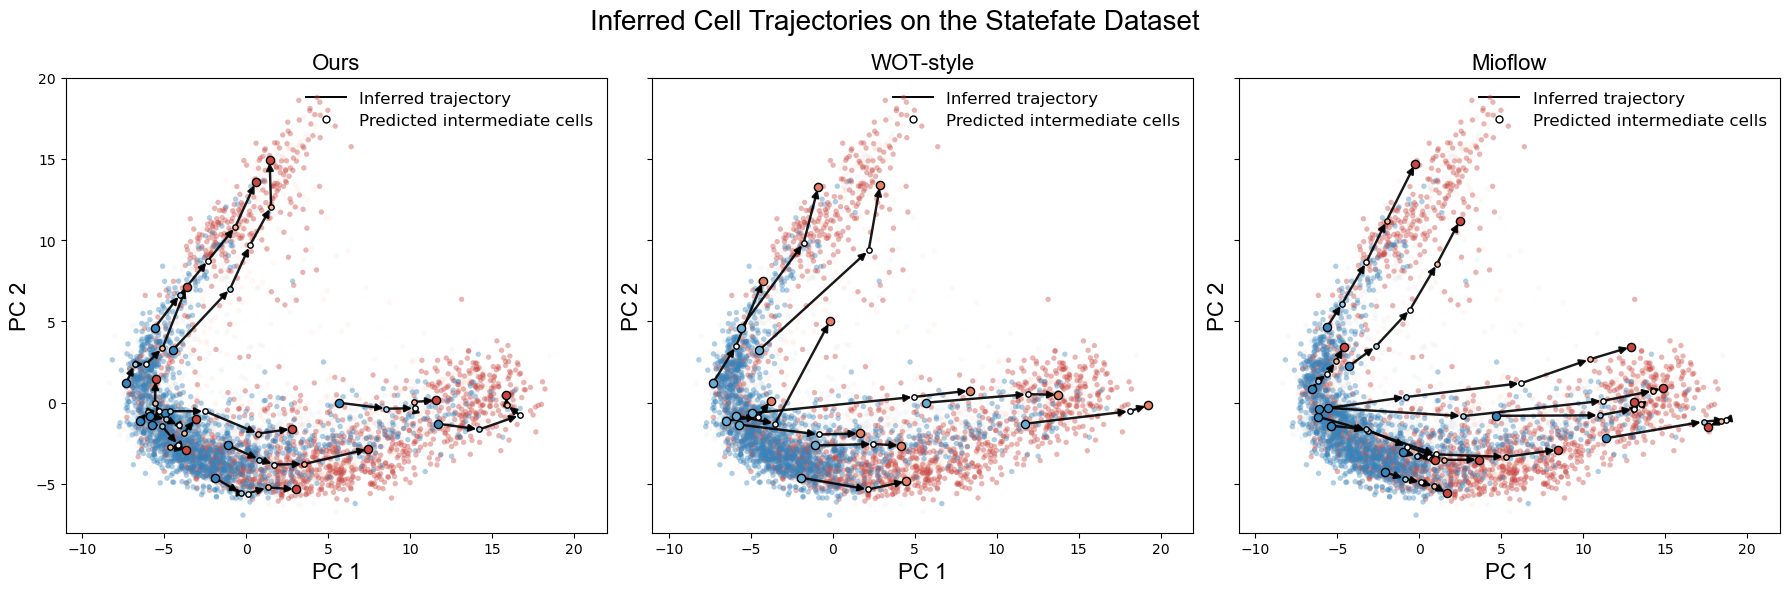

In [20]:
# --- Imports & setup ---
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# one small helper
def add_panel_legend(ax, fontsize=11, loc="upper right"):
    handles = [
        Line2D([0, 1], [0, 0], color='k', lw=1.4,
               label="Inferred trajectory"),
        Line2D([0], [0], marker='o', color='k', lw=0,
               markerfacecolor='white', markeredgecolor='black',
               markersize=5, label="Predicted intermediate cells"),
    ]
    ax.legend(handles=handles, loc=loc, frameon=False,
              fontsize=fontsize, handlelength=2.4,
              borderpad=0.3, labelspacing=0.4)

# ----------------------------
# Colors for background scatter (same as your code)
# ----------------------------
color_palette = sns.color_palette("RdBu_r", n_colors=5)          # for 9 time labels
color_dict    = dict(zip(time_labels, color_palette))            # needs time_labels in scope

# For the 5-step direct view
color_palette_2 = sns.color_palette("RdBu_r", n_colors=3)
trajectory_time_labels_2 = ['Day 2', 'Day 4','Day 6']
color_dict_2 = dict(zip(trajectory_time_labels_2, color_palette_2))

# ----------------------------
# Load transport maps and build trajectory_1 (regression, 9 steps) and trajectory_2 (direct, 5 steps)
# ----------------------------
###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
T_maps  = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/reg20/T_map_{i+1}_to_{i+2}.pt")   for i in range(4)]
T_maps2 = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/direct20/T_map_{i+1}_to_{i+2}.pt") for i in range(2)]

# Use your initial points (N, 20)
arr = np.concatenate(initial_statefate, axis=0)
data_selected = torch.from_numpy(arr).float()      # (N, 20)

# 9-step labels (match your background keys)
trajectory_time_labels = [
    'Day 2','Day 3 (predicted)','Day 4 (predicted)','Day 5 (predicted)', 'Day 6',
]

# Build trajectory_1 (regression; 9 steps)
T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
trajectory = [data_selected.detach().numpy()]
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam); T.eval()
    current_data = T(current_data)
    trajectory.append(current_data.detach().numpy())
trajectory = np.array(trajectory)   # (9, N, 20)

# Build trajectory_2 (direct; 5 steps)
trajectory_2 = [data_selected.detach().numpy()]
current_data = data_selected.clone()
for Tparam in T_maps2:
    T.load_state_dict(Tparam); T.eval()
    current_data = T(current_data)
    trajectory_2.append(current_data.detach().numpy())
trajectory_2 = np.array(trajectory_2)  # (5, N, 20)

# ----------------------------
# Load / have trajectory_3 (sampled to 9 steps): shape should be (9, N, 20): Mioflow
# ----------------------------
traj3_path = os.path.join(result_folder, "results/dynamics/statefate/trajs_3.npy")
trajectory_3 = np.load(traj3_path)

# For consistency, use the same 9-step labels/colors as trajectory_1
trajectory_time_labels_3 = trajectory_time_labels
color_dict_3 = color_dict  # reuse

# ----------------------------
# Viz parameters
# ----------------------------
marker_size = 10
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-11, 22)
y_range = (-8, 20)

z_orders = {
    'Day 2': 10,
    'Day 3 (predicted)': 2,
    'Day 4 (predicted)': 4,
    'Day 5 (predicted)': 6,
    'Day 6': 9,
}

marker_sizes = {
    'Day 2': 15,
    'Day 3 (predicted)': 15,
    'Day 4 (predicted)': 15,
    'Day 5 (predicted)': 15,
    'Day 6': 15,
}

alpha_values = {
    'Day 2': 0.4,
    'Day 3 (predicted)': 0.1,
    'Day 4 (predicted)': 0.1,
    'Day 5 (predicted)': 0.1,
    'Day 6': 0.4,
}

def plot_background(ax):
    """Scatter the background by time_labels using color_dict/alpha_values."""
    for label in time_labels:
        data = data_dict[label]
        ax.scatter(
            data[:1500, 0], data[:1500, 1],
            c=[color_dict[label]],
            label=label,
            s=marker_sizes.get(label, 10),
            alpha=alpha_values.get(label, 0.2),
            edgecolors='none',
            zorder=z_orders.get(label, 1)
        )
    ax.set_xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
    ax.set_ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

def draw_arrow(ax, x0, y0, x1, y1, color, lw=1.0, alpha=0.9, z=11, ms=10):
    """Add a single arrow from (x0,y0) to (x1,y1)."""
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='-|>', mutation_scale=ms,
                            lw=lw, color=color, alpha=alpha, zorder=z)
    ax.add_patch(arrow)

# ----------------------------
# 1×3 plot
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Left: trajectory_1 (Regression)
ax = axes[0]
plot_background(ax)
num_points = trajectory.shape[1]
for i in range(num_points):
    # if(i==3): continue #3 or 8
    for j in range(len(trajectory) - 1):
        draw_arrow(ax,
                   trajectory[j, i, 0],   trajectory[j, i, 1],
                   trajectory[j+1, i, 0], trajectory[j+1, i, 1],
                   color="black", lw=1.75, alpha=0.9, z=11, ms=10)
        step_label = trajectory_time_labels[j]
        if j == 0:
            s_size = 35
        else: 
            s_size = 15
        ax.scatter(trajectory[j, i, 0], trajectory[j, i, 1],
                   color=[color_dict[step_label]],
                   s=s_size, edgecolors='black', linewidth=1, zorder=12)
    ax.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1],
               color=[color_dict[trajectory_time_labels[-1]]],
               s=35, edgecolors='black', linewidth=1, zorder=12)
ax.set_title("Ours",
             fontsize=font_size_title, fontfamily=font_family)
add_panel_legend(axes[0], fontsize=12, loc="upper right")

# Middle: trajectory_2 (Direct)
ax = axes[1]
plot_background(ax)
num_points2 = trajectory_2.shape[1]
for i in range(num_points2):
    # if(i==3): continue
    for j in range(len(trajectory_2) - 1):
        draw_arrow(ax,
                   trajectory_2[j, i, 0],   trajectory_2[j, i, 1],
                   trajectory_2[j+1, i, 0], trajectory_2[j+1, i, 1],
                   color="black", lw=1.75, alpha=0.9, z=11, ms=10)
        step_label = trajectory_time_labels_2[j]
        if j == 0:
            s_size = 35
        else: 
            s_size = 15
        ax.scatter(trajectory_2[j, i, 0], trajectory_2[j, i, 1],
                   color=[color_dict_2[step_label]],
                   s=s_size, edgecolors='black', linewidth=1, zorder=12)
    ax.scatter(trajectory_2[-1, i, 0], trajectory_2[-1, i, 1],
               color=[color_dict_2[trajectory_time_labels_2[-1]]],
               s=35, edgecolors='black', linewidth=1, zorder=12)
ax.set_title("WOT-style",
             fontsize=font_size_title, fontfamily=font_family)
add_panel_legend(axes[1], fontsize=12, loc="upper right")

# Right: trajectory_3 (Sampled 9 steps)
ax = axes[2]
plot_background(ax)
num_points3 = trajectory_3.shape[1]
for i in range(num_points3):
    # if(i==3): continue
    for j in range(len(trajectory_3) - 1):
        draw_arrow(ax,
                   trajectory_3[j, i, 0],   trajectory_3[j, i, 1],
                   trajectory_3[j+1, i, 0], trajectory_3[j+1, i, 1],
                   color="black", lw=1.75, alpha=0.9, z=11, ms=10)
        step_label = trajectory_time_labels_3[j]
        if j == 0:
            s_size = 35
        else: 
            s_size = 15
        ax.scatter(trajectory_3[j, i, 0], trajectory_3[j, i, 1],
                   color=[color_dict_3[step_label]],
                   s=s_size, edgecolors='black', linewidth=1, zorder=12)
    ax.scatter(trajectory_3[-1, i, 0], trajectory_3[-1, i, 1],
               color=[color_dict_3[trajectory_time_labels_3[-1]]],
               s=35, edgecolors='black', linewidth=1, zorder=12)
ax.set_title("Mioflow",
             fontsize=font_size_title, fontfamily=font_family)
add_panel_legend(axes[2], fontsize=12, loc="upper right")

# (Optionally re-apply x/y label sizes if plot_background sets them)
for ax in axes:
    ax.set_xlabel("PC 1", fontsize=16, fontfamily=font_family)
    ax.set_ylabel("PC 2", fontsize=16, fontfamily=font_family)

# ---- Combined legend on the RIGHT (arrow vs point) ----
# proxy artists
# arrow_handle = Line2D([0, 1], [0, 0], color='k', lw=1.4, label="Inferred trajectory (arrow)")
# point_handle = Line2D([0], [0], marker='o', color='k',
#                       markerfacecolor='gray', markeredgecolor='black',
#                       markersize=6, lw=0, label="Predicted position (intermediate)")

# handles = [arrow_handle, point_handle]

# # leave room on right; place legend there
# plt.subplots_adjust(right=0.82, top=0.88)
# fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.84, 0.5),
#            frameon=False, ncol=1)

# ---- Common title ----
fig.suptitle("Inferred Cell Trajectories on the Statefate Dataset",
             fontsize=20, fontfamily=font_family)

plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

def _style_axes_box(ax, xlim=None, ylim=None, xlabel="PC1", ylabel="PC2",
                    spine_lw=1.0, tick_size=10, label_size=12, title_size=14):
    # box-like frame
    for s in ax.spines.values():
        s.set_visible(True)
        s.set_linewidth(spine_lw)
    ax.tick_params(axis='both', labelsize=tick_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    if xlim is not None: ax.set_xlim(*xlim)
    if ylim is not None: ax.set_ylim(*ylim)
    ax.grid(False)

def _draw_arrow(ax, x0, y0, x1, y1, lw=1.6, alpha=0.95, z=11, ms=9):
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='-|>', mutation_scale=ms,
                            lw=lw, color='k', alpha=alpha, zorder=z)
    ax.add_patch(arrow)

def _plot_background(ax, data_dict, time_labels, color_dict,
                     sizes=None, alphas=None, orders=None, cap_per_label=1500):
    for lab in time_labels:
        pts = data_dict[lab]
        pts = pts[:cap_per_label]
        ax.scatter(pts[:, 0], pts[:, 1],
                   c=[color_dict[lab]], s=(sizes or {}).get(lab, 10),
                   alpha=(alphas or {}).get(lab, 0.15),
                   edgecolors='none',
                   zorder=(orders or {}).get(lab, 1))

def plot_traj_1x3_harmonized(
    traj_list,                 # [trajA, trajB, trajC] each shape (T, N, D>=2)
    titles,                    # ["Ours", "WOT-style", "Mioflow"]
    suptitle="Inferred Cell Trajectories",
    # background
    bg_data_dict=None,         # dict[label] -> (M,2) for PC1/PC2
    bg_time_labels=None,
    bg_color_dict=None,
    bg_sizes=None, bg_alphas=None, bg_orders=None,
    # per-panel node color mapping (time-step labels & color dicts)
    per_panel_step_labels=None,# [labelsA, labelsB, labelsC] (len T)
    per_panel_step_colors=None,# [dictA, dictB, dictC]
    # view
    xlim=None, ylim=None,
    start_size=36, mid_size=16, end_size=36,
    spine_lw=1.0, label_size=13, title_size=15, tick_size=10
):
    assert len(traj_list) == 3 and len(titles) == 3
    if per_panel_step_labels is None:
        per_panel_step_labels = [None, None, None]
    if per_panel_step_colors is None:
        per_panel_step_colors = [None, None, None]

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=160, sharex=True, sharey=True)

    for ax, traj, panel_title, step_labels, step_colors in zip(
            axes, traj_list, titles, per_panel_step_labels, per_panel_step_colors):
        # background first
        if bg_data_dict is not None:
            _plot_background(ax, bg_data_dict, bg_time_labels, bg_color_dict,
                             sizes=bg_sizes, alphas=bg_alphas, orders=bg_orders)

        T, N, D = traj.shape
        assert D >= 2, "Trajectories must include PC1/PC2 in columns 0/1."

        # draw per-point polyline with arrows and colored nodes
        for i in range(N):
            for t in range(T - 1):
                x0, y0 = traj[t, i, 0],   traj[t, i, 1]
                x1, y1 = traj[t+1, i, 0], traj[t+1, i, 1]
                _draw_arrow(ax, x0, y0, x1, y1, lw=1.6, ms=9, alpha=0.95)

                # node color by step label if provided
                if step_labels is not None and step_colors is not None:
                    c = step_colors[step_labels[t]]
                else:
                    c = "white"

                size = start_size if t == 0 else mid_size
                ax.scatter(x0, y0, s=size, c=[c],
                           edgecolors='black', linewidths=0.9, zorder=12)
            # last node
            last_c = step_colors[step_labels[-1]] if (step_labels and step_colors) else "white"
            ax.scatter(traj[-1, i, 0], traj[-1, i, 1],
                       s=end_size, c=[last_c],
                       edgecolors='black', linewidths=0.9, zorder=12)

        _style_axes_box(ax, xlim=xlim, ylim=ylim,
                        xlabel="PC 1", ylabel="PC 2",
                        spine_lw=spine_lw, tick_size=tick_size, label_size=label_size)
        ax.set_title(panel_title, fontsize=title_size)

    # --- harmonized legend on the FAR RIGHT (like your medoid fig) ---
    handles = [
        Line2D([0, 1], [0, 0], color='k', lw=1.6, label='Trajectory'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='white',
               markeredgecolor='black', markersize=6, lw=0,
               label='Pred. cells'),
    ]
    # reserve space on the right
    plt.subplots_adjust(right=0.82)
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.84, 0.5),
               frameon=False, ncol=1)

    # common title & tight layout (same pattern as your second fig)
    fig.suptitle(suptitle, size=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.82, 0.95])
    plt.show()


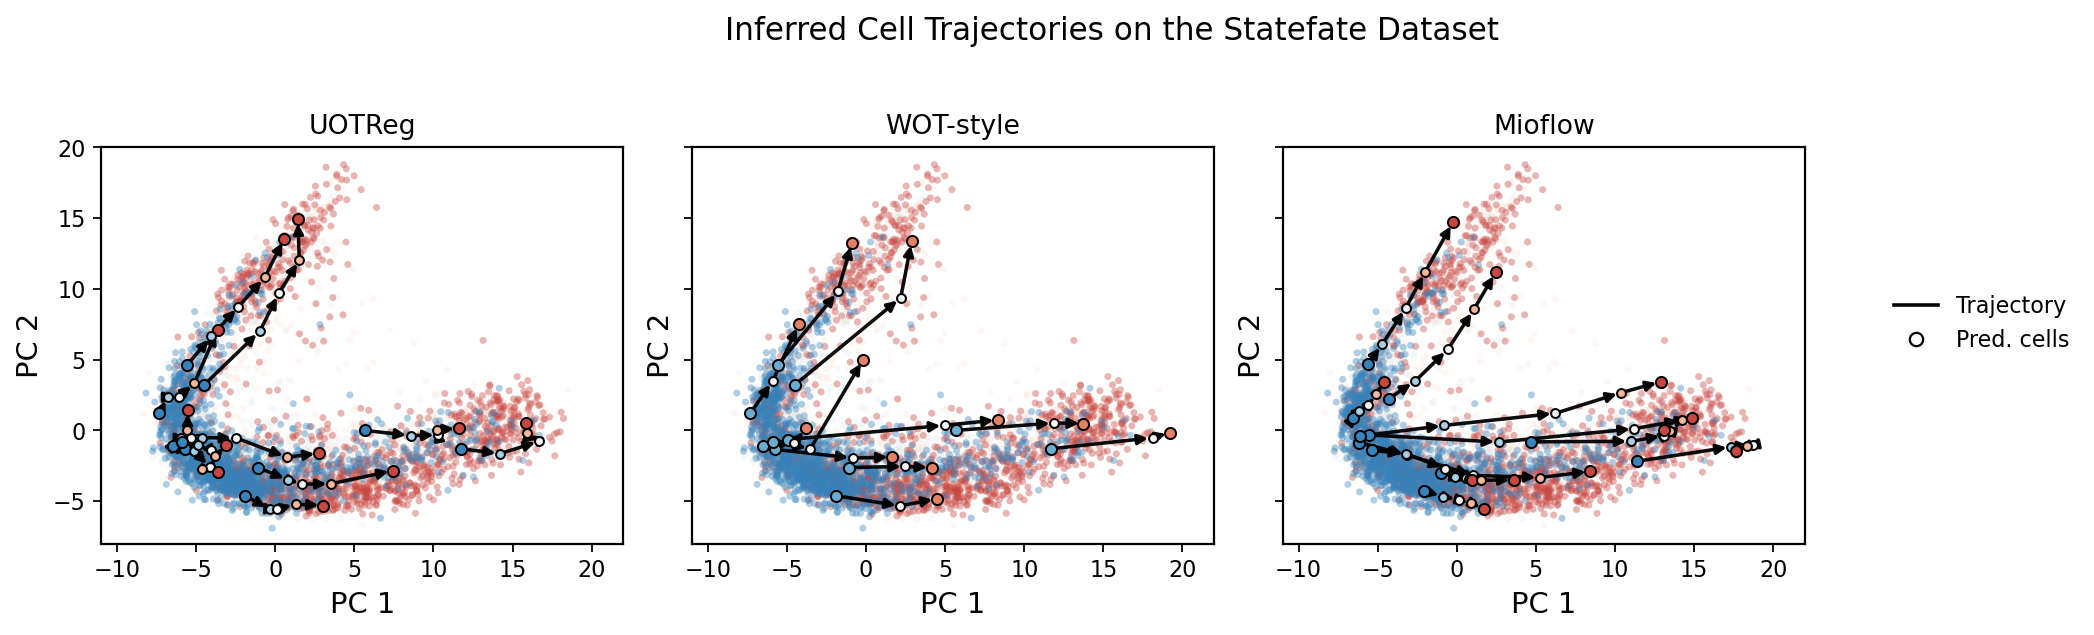

In [22]:
marker_sizes = {
    'Day 2': 10,
    'Day 3 (predicted)': 10,
    'Day 4 (predicted)': 10,
    'Day 5 (predicted)': 10,
    'Day 6': 10,
}

plot_traj_1x3_harmonized(
    traj_list=[trajectory, trajectory_2, trajectory_3],
    titles=["UOTReg", "WOT-style", "Mioflow"],
    suptitle="Inferred Cell Trajectories on the Statefate Dataset",
    # background (reuses your dicts)
    bg_data_dict=data_dict,
    bg_time_labels=time_labels,
    bg_color_dict=color_dict,
    bg_sizes=marker_sizes,
    bg_alphas=alpha_values,
    bg_orders=z_orders,
    # per-panel node colors
    per_panel_step_labels=[trajectory_time_labels,
                           trajectory_time_labels_2,
                           trajectory_time_labels_3],
    per_panel_step_colors=[color_dict, color_dict_2, color_dict_3],
    # view & styling (match your medoid plot vibe)
    xlim=(-11, 22), ylim=(-8, 20),
    spine_lw=1.0, label_size=13, title_size=12, tick_size=10,
    start_size=25, mid_size=16, end_size=25
)
